In [2]:
!pip install tensorflow-hub

In [3]:
!pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 5.1 MB/s 


In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation, Dropout, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [7]:
fake=pd.read_csv('https://raw.githubusercontent.com/shinjondas/fake-news-detection/main/data/Fake.csv')
true=pd.read_csv('https://raw.githubusercontent.com/shinjondas/fake-news-detection/main/data/True.csv')

In [8]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
fake['class'] =1
true['class']=0

In [10]:
true.head()

,title,text,subject,date,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [11]:
true['text']=true['title']+true['text']
fake['text']=fake['title']+fake['text']

In [12]:
true['text']=true['text'].apply(lambda x:str(x).lower())
fake['text']=fake['text'].apply(lambda x:str(x).lower())

In [13]:
fake=fake[['text','class']]
true=true[['text','class']]

In [14]:
data=true.append(fake,ignore_index=True)

In [15]:
from sklearn.utils import shuffle
data = shuffle(data)

In [16]:
data.groupby('class').describe()

text                                                               
       count unique                                                top freq
class                                                                      
0      21417  21197  highlights: the trump presidency on april 13 a...    8
1      23481  17908  elementary school plans ‘blacks only’ field tr...    4

In [17]:
data['class'].value_counts()

1    23481
0    21417
Name: class, dtype: int64

In [18]:
data_fake=fake.sample(true.shape[0])

In [19]:
data_fake.shape

(21417, 2)

In [20]:
data_balanced=pd.concat([true,data_fake])

In [21]:
data_balanced.shape

(42834, 2)

In [22]:
data_balanced.groupby('class').describe()

text                                                               
       count unique                                                top freq
class                                                                      
0      21417  21197  highlights: the trump presidency on april 13 a...    8
1      21417  16743  elementary school plans ‘blacks only’ field tr...    4

In [23]:
data_balanced.sample(10)

,text,class
17860,philippines doctor linked to new york attack p...,0
18855,"hope evaporating, a grim wait for relatives af...",0
9620,house to introduce puerto rico crisis bill on ...,0
14902,exclusive: kremlin tells companies to deliver ...,0
3324,fox news host bill o’reilly literally just en...,1
5427,palestinians tell trump they are still committ...,0
1192,newt gingrich’s new tell-all book reveals tru...,1
904,paul ryan refuses to hold town halls because ...,1
6575,trump picks his company lawyer for special neg...,0
771,republican official caught exposing himself a...,1


In [38]:
X_train,X_test,y_train,y_test=train_test_split(data_balanced['text'],data_balanced['class'],stratify=data_balanced['class'])

In [39]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [40]:
def get_sentence_embedding(sentence):
  text=bert_preprocess(sentence)
  return bert_encoder(text)['pooled_output']

In [41]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [42]:
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [43]:
model_BERT = tf.keras.Model(inputs=[text_input], outputs = [l])

In [44]:
model_BERT.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [45]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model_BERT.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [46]:
model_BERT.fit(X_train,y_train,epochs=10)

Epoch 1/10
1004/1004 [==============================] - 363s 348ms/step - loss: 0.3245 - accuracy: 0.8849 - precision: 0.8854 - recall: 0.8843
Epoch 2/10
1004/1004 [==============================] - 354s 353ms/step - loss: 0.1988 - accuracy: 0.9308 - precision: 0.9284 - recall: 0.9336
Epoch 3/10
1004/1004 [==============================] - 354s 353ms/step - loss: 0.1715 - accuracy: 0.9385 - precision: 0.9378 - recall: 0.9392
Epoch 4/10
1004/1004 [==============================] - 355s 353ms/step - loss: 0.1618 - accuracy: 0.9397 - precision: 0.9398 - recall: 0.9395
Epoch 5/10
1004/1004 [==============================] - 355s 353ms/step - loss: 0.1529 - accuracy: 0.9433 - precision: 0.9434 - recall: 0.9432
Epoch 6/10
1004/1004 [==============================] - 355s 353ms/step - loss: 0.1475 - accuracy: 0.9449 - precision: 0.9451 - recall: 0.9448
Epoch 7/10
1004/1004 [==============================] - 354s 353ms/step - loss: 0.1405 - accuracy: 0.9482 - precision: 0.9478 - recall: 0.9487

In [48]:
model_BERT.evaluate(X_test, y_test)

335/335 [==============================] - 115s 341ms/step - loss: 0.1107 - accuracy: 0.9604 - precision: 0.9628 - recall: 0.9578


[0.11066899448633194,
 0.9604071378707886,
 0.9628308415412903,
 0.9577964544296265]

In [49]:
y_predict=(model_BERT.predict(X_test)>=0.5).astype(int)

In [51]:
y_predict.flatten()

array([1, 1, 1, ..., 1, 1, 0])

In [52]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5354
           1       0.96      0.96      0.96      5355

    accuracy                           0.96     10709
   macro avg       0.96      0.96      0.96     10709
weighted avg       0.96      0.96      0.96     10709



Text(33.0, 0.5, 'Test Data')

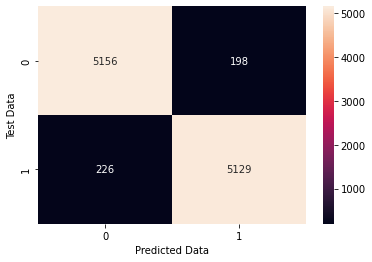

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predict)
cm 
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Data')
plt.ylabel('Test Data')

In [70]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predict)

0.9604071341861985

In [71]:
from sklearn.metrics import precision_score
precision_score(y_test, y_predict, average='macro')

0.9604195185238436